# Analyze results of Timeloop/Accelergy on NeRF

In [1]:
import json
import os
import pandas as pd
import regex as re

from notebook_utils import load_mpl_style
load_mpl_style()

In [2]:
!ls dot-product_profile_results

eyeriss_like_onchip_compression_results.json
eyeriss_like_results.json
eyeriss_like_w_gating_results.json
results.json


## Load Results from the Profile notebok

In [3]:
def load_results(results_path: str = "dot-product_profile_results/results.json") -> dict:
    """ Load results from Profile NeRF.ipynb notebook back into original shape. """
    with open(results_path, "r") as f:
        results = json.load(f)
    print(f"Loaded results from {results_path}")

    for arch, arch_result_dict in results.items():
        arch_results_path = arch_result_dict["results"]
        assert os.path.exists(arch_results_path), f"Could not find {arch_results_path} for {arch}"

        with open(arch_results_path, "r") as f:
            arch_result_dict["results"] = json.load(f)    
        print(f"Populated {arch} results from {arch_results_path}")
        
    return results

profile_results = load_results()

Loaded results from dot-product_profile_results/results.json
Populated eyeriss_like results from /home/workspace/notebooks/dot-product_profile_results/eyeriss_like_results.json
Populated eyeriss_like_onchip_compression results from /home/workspace/notebooks/dot-product_profile_results/eyeriss_like_onchip_compression_results.json
Populated eyeriss_like_w_gating results from /home/workspace/notebooks/dot-product_profile_results/eyeriss_like_w_gating_results.json


## Analyze

In [4]:
# Compute the actual area as the summary got it wrong
area_regex = r"Area.*:\s(\d+.\d+)"

for arch, arch_results in profile_results.items():
    arch_total_area = 0.0
    layer_summary = arch_results["layer_summary"]
    
    for layer_id in layer_summary:
        # Read all areas from the timeloop stats file
        stats_fname = layer_summary[layer_id]["stats_fname"]
        with open(stats_fname, "r") as f:
            stats = [l.strip() for l in f.readlines()]

        area_lines = [line for line in stats[:-50] if re.match(area_regex, line)]
        areas = [re.search(area_regex, line).group(1) for line in area_lines]
        areas = [float(area) for area in areas]
        assert len(areas) == 7
        area = sum(areas)
        
        # Need to multiply by number of this layer type
        num = layer_summary[layer_id]["num"]
        total_area = area * num
        
        layer_summary[layer_id]["actual_total_area"] = total_area
        layer_summary[layer_id]["actual_area"] = area
        arch_total_area += total_area
        
    arch_results["summary"]["actual_total_area"] = arch_total_area

In [5]:
# Massage results into dataframes
layer_dfs = {}
all_summary = {}
# Remove area and total_area as they are wrong as just 0.0
drop_cols = ["name", "stats_fname", "total_area", "area"]

for arch, arch_results in profile_results.items():
    all_summary[arch] = arch_results["summary"]

    # Load layer results into dataframe
    df_layer = pd.DataFrame.from_dict(arch_results["layer_summary"], orient="index")
    df_layer = df_layer.drop(columns=drop_cols)
    df_layer.index.name = "layer_id"
    layer_dfs[arch] = df_layer
        
df_summary = pd.DataFrame.from_dict(all_summary, orient="index")
df_summary = df_summary.drop(columns=["total_area"])

In [6]:
layer_dfs["eyeriss_like"]

,total_energy,total_cycle,num,energy,cycle,gflops,utilization,edp,actual_total_area,actual_area
layer_id,,,,,,,,,,
1,0.04,16,1,0.04,16,15.94,0.05,6.240000e-07,1375449.72,1375449.72


In [7]:
layer_dfs["eyeriss_like_onchip_compression"]

,total_energy,total_cycle,num,energy,cycle,gflops,utilization,edp,actual_total_area,actual_area
layer_id,,,,,,,,,,
1,0.03,11,1,0.03,11,15.36,0.05,3.420000e-07,907149.12,907149.12
2,0.03,11,1,0.03,11,14.64,0.04,3.330000e-07,907149.12,907149.12
3,0.03,9,1,0.03,9,15.89,0.05,2.550000e-07,907149.12,907149.12
4,0.03,8,1,0.03,8,15.12,0.05,2.200000e-07,907149.12,907149.12
5,0.03,11,1,0.03,11,15.91,0.05,3.400000e-07,907149.12,907149.12
6,0.03,10,1,0.03,10,15.70,0.05,2.980000e-07,907149.12,907149.12


In [8]:
layer_dfs["eyeriss_like_w_gating"]

,total_energy,total_cycle,num,energy,cycle,gflops,utilization,edp,actual_total_area,actual_area
layer_id,,,,,,,,,,
1,0.03,11,1,0.03,11,15.36,0.05,3.500000e-07,854095.4,854095.4
2,0.03,11,1,0.03,11,14.64,0.04,3.420000e-07,854095.4,854095.4
3,0.03,9,1,0.03,9,15.89,0.05,2.650000e-07,854095.4,854095.4
4,0.03,9,1,0.03,9,13.44,0.04,2.580000e-07,854095.4,854095.4
5,0.03,11,1,0.03,11,15.91,0.05,3.480000e-07,854095.4,854095.4
6,0.03,10,1,0.03,10,15.70,0.05,3.060000e-07,854095.4,854095.4


In [9]:
df_summary

,total_energy,total_cycle,actual_total_area
eyeriss_like,0.04,16.0,1375449.72
eyeriss_like_onchip_compression,0.18,60.0,5442894.72
eyeriss_like_w_gating,0.18,61.0,5124572.40


In [10]:
edp = df_summary["total_energy"] * df_summary["total_cycle"]
df_summary["EDP (J*cycle)"] = edp

## Save results to LaTeX table

In [11]:
arch_to_label = {
    "eyeriss_like": "Eyeriss",
    "eyeriss_like_w_gating": "w/ Gating",
    "eyeriss_like_onchip_compression": "w/ Onchip Compression",
    "eyeriss_like_shen": "w/ Shen",
}
cols = ["Energy ($\mu\text{J}$)", "Cycles", "EDP (J*cycle)", "Area ($\text{mm}^2$)"]

df_output = df_summary.copy()
df_output.index = [arch_to_label[arch] for arch in df_output.index.values]

df_output["Energy ($\mu\text{J}$)"] = df_output["total_energy"]
df_output["Cycles"] = df_output["total_cycle"].astype(int)
# Convert area in um^2 to mm^2
df_output["Area ($\text{mm}^2$)"] = round(df_output["actual_total_area"] / 1e6, 2)

df_output = df_output[cols]
df_output

,Energy ($\mu\text{J}$),Cycles,EDP (J*cycle),Area ($\text{mm}^2$)
Eyeriss,0.04,16,0.64,1.38
w/ Onchip Compression,0.18,60,10.80,5.44
w/ Gating,0.18,61,10.98,5.12


In [12]:
print(df_output.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & Energy ($\mu	ext{J}$) & Cycles & EDP (J*cycle) & Area ($	ext{mm}^2$) \\
\midrule
Eyeriss & 0.040000 & 16 & 0.640000 & 1.380000 \\
w/ Onchip Compression & 0.180000 & 60 & 10.800000 & 5.440000 \\
w/ Gating & 0.180000 & 61 & 10.980000 & 5.120000 \\
\bottomrule
\end{tabular}



In [13]:
df_output = pd.concat([layer_dfs["eyeriss_like"].head(1), layer_dfs["eyeriss_like_onchip_compression"].head(1), layer_dfs["eyeriss_like_w_gating"].head(1)])
df_output.index = ["Eyeriss", "w/ Onchip Compression", "w/ Gating"]

cols = ["Energy ($\mu\text{J}$)", "Cycles", "EDP (J*cycle)", "Area ($\text{mm}^2$)"]

df_output["EDP (J*cycle)"] = df_output["edp"]
df_output["Energy ($\mu\text{J}$)"] = df_output["total_energy"]
df_output["Cycles"] = df_output["total_cycle"].astype(int)
# Convert area in um^2 to mm^2
df_output["Area ($\text{mm}^2$)"] = round(df_output["actual_total_area"] / 1e6, 2)

df_output = df_output[cols]

final_graph = {}
final_graph["default"] = {"avg": 6.240000e-07, "chair": 6.240000e-07, "drum": 6.240000e-07, "ficus": 6.240000e-07, "hotdog": 6.240000e-07, "lego": 6.240000e-07}
df_output

,Energy ($\mu\text{J}$),Cycles,EDP (J*cycle),Area ($\text{mm}^2$)
Eyeriss,0.04,16,6.240000e-07,1.38
w/ Onchip Compression,0.03,11,3.420000e-07,0.91
w/ Gating,0.03,11,3.500000e-07,0.85


In [14]:
print(df_output.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & Energy ($\mu	ext{J}$) & Cycles & EDP (J*cycle) & Area ($	ext{mm}^2$) \\
\midrule
Eyeriss & 0.040000 & 16 & 0.000001 & 1.380000 \\
w/ Onchip Compression & 0.030000 & 11 & 0.000000 & 0.910000 \\
w/ Gating & 0.030000 & 11 & 0.000000 & 0.850000 \\
\bottomrule
\end{tabular}



In [15]:
df_output = layer_dfs["eyeriss_like_onchip_compression"].copy()
df_output.index = ["avg", "chair", "drum", "ficus", "hotdog", "lego"]

cols = ["Energy ($\mu\text{J}$)", "Cycles", "EDP (J*cycle)", "Area ($\text{mm}^2$)"]

df_output["EDP (J*cycle)"] = df_output["edp"]
df_output["Energy ($\mu\text{J}$)"] = df_output["total_energy"]
df_output["Cycles"] = df_output["total_cycle"].astype(int)
# Convert area in um^2 to mm^2
df_output["Area ($\text{mm}^2$)"] = round(df_output["actual_total_area"] / 1e6, 2)

df_output = df_output[cols]

final_graph["onchip_compression"] = df_output["EDP (J*cycle)"]
print(df_output.to_latex())

df_output

\begin{tabular}{lrrrr}
\toprule
 & Energy ($\mu	ext{J}$) & Cycles & EDP (J*cycle) & Area ($	ext{mm}^2$) \\
\midrule
avg & 0.030000 & 11 & 0.000000 & 0.910000 \\
chair & 0.030000 & 11 & 0.000000 & 0.910000 \\
drum & 0.030000 & 9 & 0.000000 & 0.910000 \\
ficus & 0.030000 & 8 & 0.000000 & 0.910000 \\
hotdog & 0.030000 & 11 & 0.000000 & 0.910000 \\
lego & 0.030000 & 10 & 0.000000 & 0.910000 \\
\bottomrule
\end{tabular}



In [20]:
df_output = layer_dfs["eyeriss_like_w_gating"].copy()
df_output.index = ["avg", "chair", "drum", "ficus", "hotdog", "lego"]

cols = ["Energy ($\mu\text{J}$)", "Cycles", "EDP (J*cycle)", "Area ($\text{mm}^2$)"]

df_output["EDP (J*cycle)"] = df_output["edp"]
df_output["Energy ($\mu\text{J}$)"] = df_output["total_energy"]
df_output["Cycles"] = df_output["total_cycle"].astype(int)
# Convert area in um^2 to mm^2
df_output["Area ($\text{mm}^2$)"] = round(df_output["actual_total_area"] / 1e6, 2)

df_output = df_output[cols]

final_graph["gating"] = df_output["EDP (J*cycle)"]
print(df_output.to_latex())

df_output

\begin{tabular}{lrrrr}
\toprule
 & Energy ($\mu	ext{J}$) & Cycles & EDP (J*cycle) & Area ($	ext{mm}^2$) \\
\midrule
avg & 0.030000 & 11 & 0.000000 & 0.850000 \\
chair & 0.030000 & 11 & 0.000000 & 0.850000 \\
drum & 0.030000 & 9 & 0.000000 & 0.850000 \\
ficus & 0.030000 & 9 & 0.000000 & 0.850000 \\
hotdog & 0.030000 & 11 & 0.000000 & 0.850000 \\
lego & 0.030000 & 10 & 0.000000 & 0.850000 \\
\bottomrule
\end{tabular}



,Energy ($\mu\text{J}$),Cycles,EDP (J*cycle),Area ($\text{mm}^2$)
avg,0.03,11,3.500000e-07,0.85
chair,0.03,11,3.420000e-07,0.85
drum,0.03,9,2.650000e-07,0.85
ficus,0.03,9,2.580000e-07,0.85
hotdog,0.03,11,3.480000e-07,0.85
lego,0.03,10,3.060000e-07,0.85


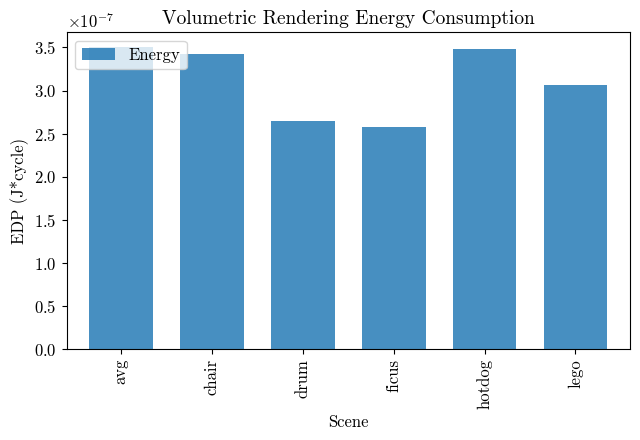

In [21]:
ax = df_output.plot.bar(
    y=["EDP (J*cycle)"], 
    width=0.7, figsize=(6.5, 4.5), align="center", alpha=0.825
)
ax.set_ylim(bottom=0.00)
ax.legend(['Energy'], loc="upper left", ncol=2, columnspacing=0.65)

ax.set_title("Volumetric Rendering Energy Consumption")
ax.set_xlabel("Scene")
ax.set_ylabel("EDP (J*cycle)")
ax.figure.tight_layout()
# ax.figure.savefig(f"{fig_dir}/quantization_results.pdf")
# ax.figure.savefig("../assets/quantization-results.png", dpi=300)

In [23]:
df_output = pd.DataFrame.from_dict(final_graph)
print(df_output.to_latex())
df_output

\begin{tabular}{lrrr}
\toprule
 & default & onchip_compression & gating \\
\midrule
avg & 0.000001 & 0.000000 & 0.000000 \\
chair & 0.000001 & 0.000000 & 0.000000 \\
drum & 0.000001 & 0.000000 & 0.000000 \\
ficus & 0.000001 & 0.000000 & 0.000000 \\
hotdog & 0.000001 & 0.000000 & 0.000000 \\
lego & 0.000001 & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}



,default,onchip_compression,gating
avg,6.240000e-07,3.420000e-07,3.500000e-07
chair,6.240000e-07,3.330000e-07,3.420000e-07
drum,6.240000e-07,2.550000e-07,2.650000e-07
ficus,6.240000e-07,2.200000e-07,2.580000e-07
hotdog,6.240000e-07,3.400000e-07,3.480000e-07
lego,6.240000e-07,2.980000e-07,3.060000e-07


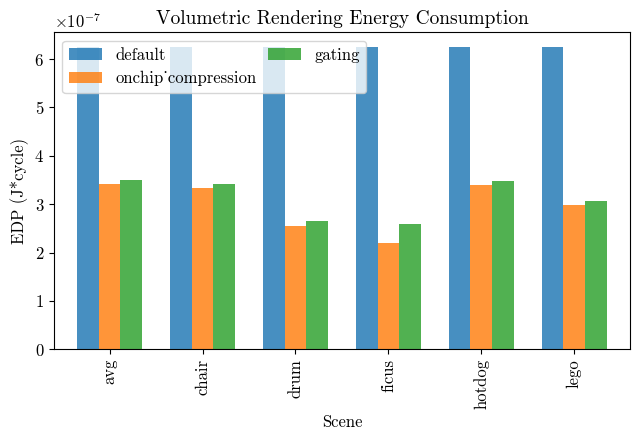

In [19]:
ax = df_output.plot.bar(
    y=["default", "onchip_compression", "gating"], 
    width=0.7, figsize=(6.5, 4.5), align="center", alpha=0.825
)
ax.set_ylim(bottom=0.00)
ax.legend(["default", "onchip_compression", "gating"], loc="upper left", ncol=2, columnspacing=0.65)

ax.set_title("Volumetric Rendering Energy Consumption")
ax.set_xlabel("Scene")
ax.set_ylabel("EDP (J*cycle)")
ax.figure.tight_layout()
ax.figure.savefig(f"figures/volrend/dot-product_results.pdf")
ax.figure.savefig("../assets/dot-product-results.png", dpi=300)